<a href="https://colab.research.google.com/github/chamisfum/Brain_Tumor_Classification_Trial/blob/master/VGG16_trial_v5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
os.environ['CONFIG_DIR'] = "/content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset"

In [ ]:
%cd /content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset

/content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset


In [ ]:
ls

AUGMENTATION/  IMBALANCE/  SPLIT_AUGMENTATION/  trial_v5_weights2.h5
BALANCE/       percobaan/  trial_v5_model2.h5   trial_v5_weights.h5
draft/         readme.txt  trial_v5_model.h5


In [ ]:
ls AUGMENTATION/

GLIOMA/  MENINGIOMA/  PITUITARY/


In [ ]:
!pip install split-folders &> /dev/null

In [ ]:
# mkdir percobaan

mkdir: cannot create directory ‘percobaan’: File exists


In [ ]:
ls percobaan

test/  train/  val/


In [ ]:
# import splitfolders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio("AUGMENTATION", output="trial", seed=1337, ratio=(.8, .15, .05), group_prefix=None) # default values

# # Split val/test with a fixed number of items e.g. 100 for each set.
# # To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# # splitfolders.fixed("input_folder", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values


In [ ]:
def load_data(image_dir):
    images = []
    y = []
    classNum = 0
    for class1 in tqdm(os.listdir(image_dir)):
        for file_name in os.listdir(os.path.join(image_dir,class1)):
            images.append(cv2.imread(os.path.join(image_dir,class1,file_name)))
            y.append(classNum)
        classNum += 1
    print(f'Loaded {len(images)} images from {image_dir} directory')
    images = np.array(images)
    y = np.array(y)
    return images,y

In [ ]:
def show_samples(X,y,label_dict={0:'MENINGIOMA',1:'PITUITARY',2:'GLIOMA'},n=30):
    for class1 in label_dict.keys():
        imgs = X[y == class1][:n]
        j = 10
        i = n // 10
        plt.figure(figsize=(20,6))
        for (c,img) in enumerate(imgs,1):
            plt.subplot(i,j,c)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace=0, hspace=0, bottom = 0, left=0)
        plt.suptitle(f'Tumor: {label_dict[class1]}', fontsize=20)
        plt.savefig(f'Tumor_{label_dict[class1]}.png')

In [ ]:
train_images, train_labels = load_data('percobaan/train/')
val_images, val_labels = load_data('percobaan/val/')
test_images, test_labels = load_data('percobaan/test/')

train_images[0].shape

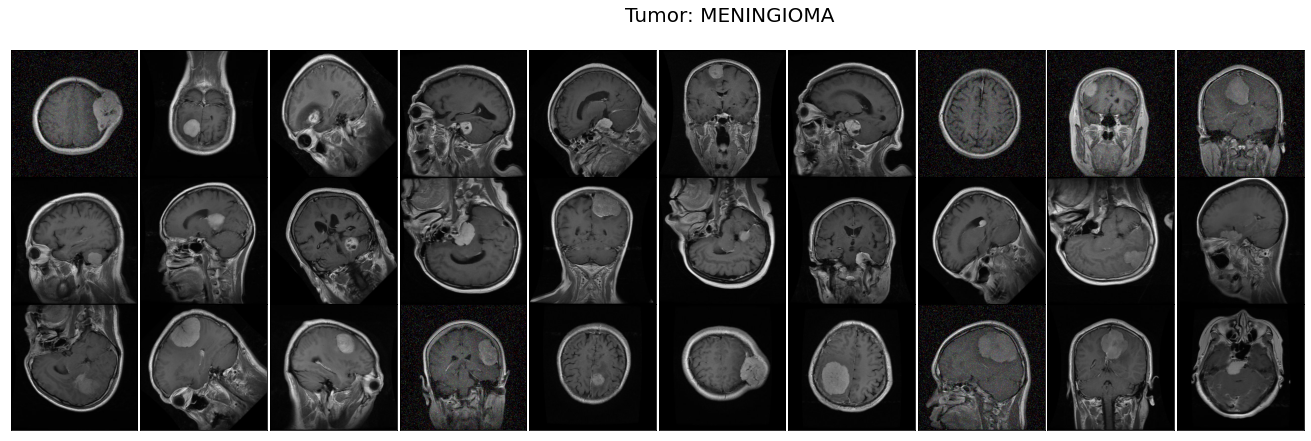

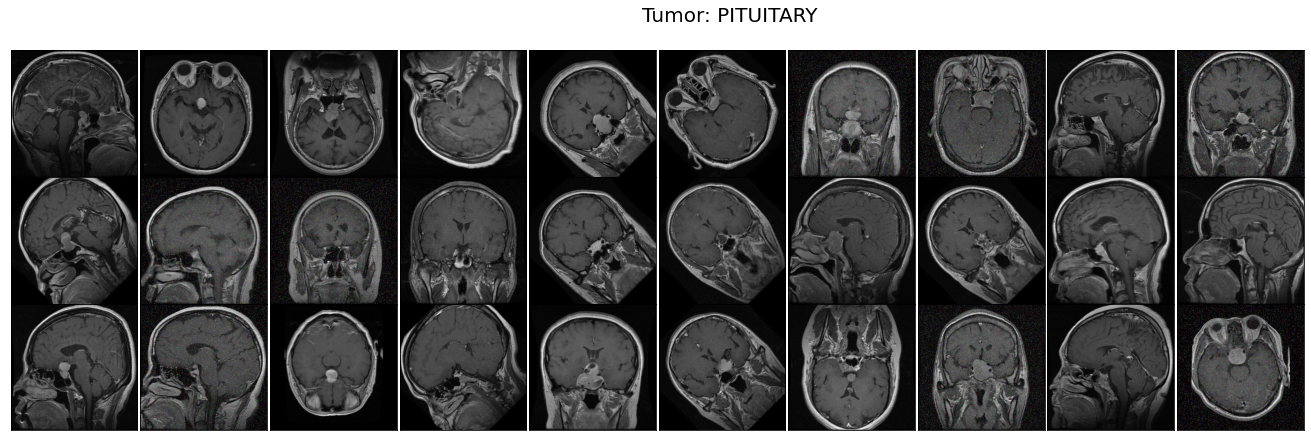

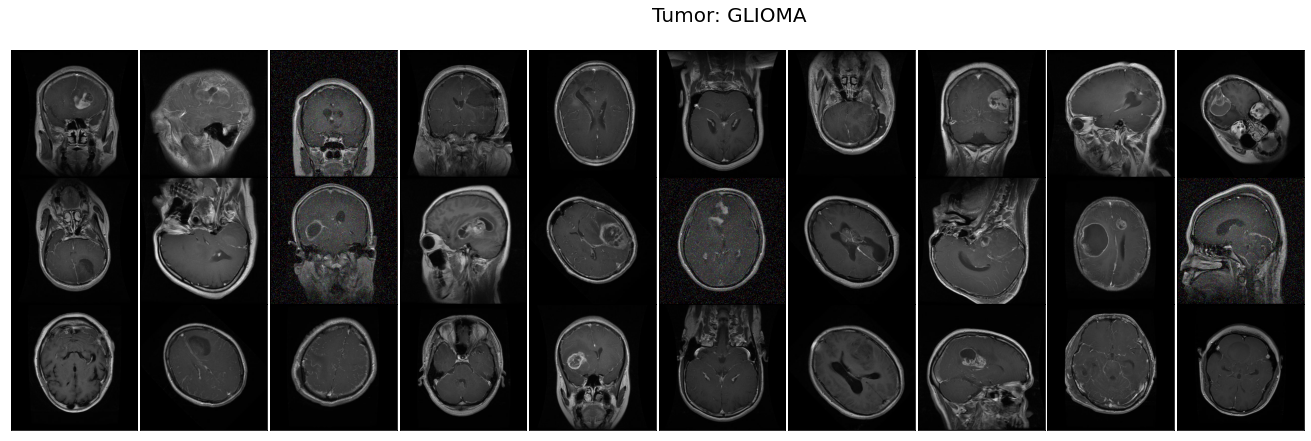

In [ ]:
show_samples(train_images,train_labels)

([<matplotlib.axis.XTick at 0x7fbae8ff73c8>,
 [Text(0, 0, 'Train'), Text(0, 0, 'Validation'), Text(0, 0, 'Test')])

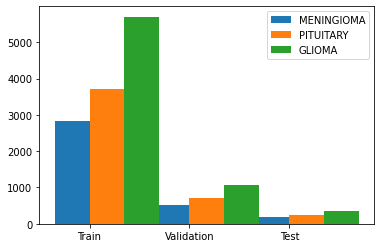

In [ ]:
data = [[(train_labels == 0).sum(),(val_labels == 0).sum(),(test_labels == 0).sum()],
        [(train_labels == 1).sum(),(val_labels == 1).sum(),(test_labels == 1).sum()],
        [(train_labels == 2).sum(),(val_labels == 2).sum(),(test_labels == 2).sum()]]

labels = ['Train', 'Validation', 'Test']
X = np.arange(3)
# GLIOMA/  MENINGIOMA/  PITUITARY/
# fig = plt.figure()
width = 0.35
plt.bar(X - width/2,data[0],width,label='MENINGIOMA')
plt.bar(X + width/2,data[1],width,label='PITUITARY')
plt.bar(X + width+0.17,data[2],width,label='GLIOMA')
plt.legend(loc='best')
plt.xticks(X,labels=labels)

In [40]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(128,128,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [42]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(300,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(Dense(3,activation='softmax'))
model.layers[0].trainable = False

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=500,
    decay_rate=0.0001)
opt = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               2457900   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 17,173,491
Trainable params: 2,458,803
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
path_train = 'percobaan/train/'
path_val = 'percobaan/val/'
path_test = 'percobaan/test/'

In [44]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255,
                            #  rotation_range=40,
                            #  width_shift_range=0.2,
                            #  height_shift_range=0.2,
                            #  shear_range=0.2,
                            #  zoom_range=0.2,
                            #  horizontal_flip=True,
                             fill_mode='nearest')

training_set = datagen.flow_from_directory(path_train,
                                           target_size=(128,128),
                                           color_mode="rgb",
                                           shuffle=False,
                                           batch_size = 64,
                                           class_mode='categorical')

validation_set = datagen.flow_from_directory(path_val,
                                             target_size=(128,128),
                                             color_mode="rgb",
                                             shuffle=False,
                                             batch_size = 64,
                                             class_mode='categorical')

testing_set = datagen.flow_from_directory(path_test,
                                          target_size=(128,128),
                                          color_mode="rgb",
                                          shuffle=False,
                                          batch_size = 64,
                                          class_mode='categorical')

Found 12256 images belonging to 3 classes.
Found 2297 images belonging to 3 classes.
Found 767 images belonging to 3 classes.


In [45]:
# Found 12256 images belonging to 3 classes.
# Found 2297 images belonging to 3 classes.
# Found 767 images belonging to 3 classes.

In [ ]:
testing_set.class_indices

{'GLIOMA': 0, 'MENINGIOMA': 1, 'PITUITARY': 2}

In [ ]:
train_step_size = training_set.n//training_set.batch_size
val_step_size = validation_set.n//validation_set.batch_size

es = EarlyStopping(
    monitor='val_loss', 
    mode='max',
    patience=6,
    restore_best_weights=True
)

In [27]:
history = model.fit(training_set, 
                    steps_per_epoch=train_step_size, 
                    epochs=100, 
                    validation_data=validation_set, 
                    validation_steps=val_step_size, 
                    callbacks=[es])

Epoch 1/100
191/191 [==============================] - 5779s 30s/step - loss: 4.2738 - accuracy: 0.6319 - val_loss: 2.0877 - val_accuracy: 0.7723
Epoch 2/100
191/191 [==============================] - 67s 352ms/step - loss: 2.0112 - accuracy: 0.7744 - val_loss: 1.9769 - val_accuracy: 0.7821
Epoch 3/100
191/191 [==============================] - 66s 348ms/step - loss: 1.9761 - accuracy: 0.7799 - val_loss: 1.9734 - val_accuracy: 0.7835
Epoch 4/100
191/191 [==============================] - 65s 343ms/step - loss: 1.9759 - accuracy: 0.7792 - val_loss: 1.9732 - val_accuracy: 0.7835
Epoch 5/100
191/191 [==============================] - 65s 342ms/step - loss: 1.9697 - accuracy: 0.7836 - val_loss: 1.9732 - val_accuracy: 0.7835
Epoch 6/100
191/191 [==============================] - 67s 350ms/step - loss: 1.9757 - accuracy: 0.7790 - val_loss: 1.9732 - val_accuracy: 0.7835
Epoch 7/100
191/191 [==============================] - 65s 342ms/step - loss: 1.9747 - accuracy: 0.7794 - val_loss: 1.9732 -

In [28]:
model.evaluate(training_set)

192/192 [==============================] - 57s 297ms/step - loss: 2.0875 - accuracy: 0.7710


[2.087468147277832, 0.7709693312644958]

In [29]:
model.evaluate(testing_set)

12/12 [==============================] - 323s 27s/step - loss: 2.0899 - accuracy: 0.7810


[2.0898947715759277, 0.7809647917747498]

In [30]:
model.evaluate(validation_set)

36/36 [==============================] - 11s 294ms/step - loss: 2.0802 - accuracy: 0.7762


[2.080171823501587, 0.7762298583984375]

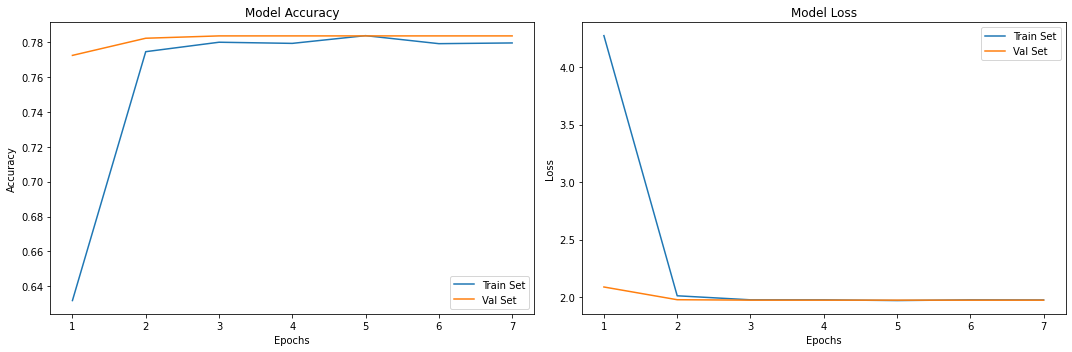

In [31]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [32]:
model.save('trial_v5_model.h5') 

In [33]:
model.save_weights("trial_v5_weights.h5")

In [39]:
ls

AUGMENTATION/  IMBALANCE/  SPLIT_AUGMENTATION/  trial_v5_weights2.h5
BALANCE/       percobaan/  trial_v5_model2.h5   trial_v5_weights.h5
draft/         readme.txt  trial_v5_model.h5
